In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/Merged_tmdb_data.csv')

df.info(),df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4793 entries, 0 to 4792
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   movie_id                     4793 non-null   int64  
 1   title_x                      4793 non-null   object 
 2   cast                         4793 non-null   object 
 3   crew                         4793 non-null   object 
 4   Adjusted_Cast                4793 non-null   object 
 5   Cast_Size                    4793 non-null   int64  
 6   Top_Cast                     4793 non-null   object 
 7   Cast_Gender_Ratio            4793 non-null   object 
 8   Adjusted_Crew                4793 non-null   object 
 9   Crew_Size                    4793 non-null   int64  
 10  Crew_Dept_Cout               4793 non-null   object 
 11  Crew_Gender_Ratio            4793 non-null   object 
 12  Cast_Crew_Ratio              4765 non-null   float64
 13  budget            

(None,
    movie_id                                   title_x  \
 0     19995                                    Avatar   
 1       285  Pirates of the Caribbean: At World's End   
 2    206647                                   Spectre   
 3     49026                     The Dark Knight Rises   
 4     49529                               John Carter   
 
                                                 cast  \
 0  [{'cast_id': 242, 'character': 'Jake Sully', '...   
 1  [{'cast_id': 4, 'character': 'Captain Jack Spa...   
 2  [{'cast_id': 1, 'character': 'James Bond', 'cr...   
 3  [{'cast_id': 2, 'character': 'Bruce Wayne / Ba...   
 4  [{'cast_id': 5, 'character': 'John Carter', 'c...   
 
                                                 crew  \
 0  [{'credit_id': '52fe48009251416c750aca23', 'de...   
 1  [{'credit_id': '52fe4232c3a36847f800b579', 'de...   
 2  [{'credit_id': '54805967c3a36829b5002c41', 'de...   
 3  [{'credit_id': '52fe4781c3a36847f81398c3', 'de...   
 4  [{'credit_

In [3]:
# Identify columns with missing data
df.drop(columns=['homepage','release_date','Cast_Crew_Ratio','tagline','overview','runtime'], inplace=True)

In [4]:
# List of columns to parse
columns_to_parse = [
    'cast', 'crew', 'genres', 'production_companies', 'spoken_languages', 
    'Adjusted_Cast', 'Top_Cast', 'Adjusted_Crew', 'Adjusted_Production_Company', 
    'Adjusted_Production_Country', 'Adjusted_Langauges', 'Adjusted_Genre'
]

# Parse columns containing stringified lists/dictionaries
for column in columns_to_parse:
    df[column] = df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [5]:
# Define a function to safely parse values
def safe_parse(value):
    """Safely parses stringified lists or dictionaries, or returns an empty list on failure."""
    try:
        if isinstance(value, str):
            parsed_value = ast.literal_eval(value)
            if isinstance(parsed_value, (list, dict)):  # Ensure parsed value is a list or dict
                return parsed_value
        elif isinstance(value, (list, dict)):
            return value  # Already a valid type
    except (ValueError, SyntaxError):
        pass
    return []  # Default to an empty list for invalid or unparseable values

# Apply parsing to columns
columns_to_parse = [
    'genres', 'production_companies', 'spoken_languages', 
    'Adjusted_Production_Company', 'Adjusted_Production_Country', 
    'Adjusted_Langauges', 'Adjusted_Genre'
]

for column in columns_to_parse:
    df[column] = df[column].apply(safe_parse)

# Define a function to extract names from lists of dictionaries
def extract_names_from_dict_list(column_data):
    """Extract 'name' field from a list of dictionaries."""
    return column_data.apply(
        lambda x: [entry.get('name', '') for entry in x if isinstance(entry, dict)] if isinstance(x, list) else []
    )

# Extract names for specified columns
for column in columns_to_parse:
    df[column] = extract_names_from_dict_list(df[column])

# Initialize MultiLabelBinarizer and encode the categorical columns
encoded_dfs = {}
for column in columns_to_parse:
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[column])
    encoded_df = pd.DataFrame(encoded, columns=[f"{column}_{label}" for label in mlb.classes_])
    encoded_dfs[column] = encoded_df

# Concatenate encoded DataFrames back into the main DataFrame
for column, encoded_df in encoded_dfs.items():
    df = pd.concat([df, encoded_df], axis=1)

# Drop original columns after encoding
df = df.drop(columns=columns_to_parse)

In [6]:
# Assuming the target variable is named 'revenue' (replace with the actual target column name)
# Drop irrelevant columns that should not be part of training
irrelevant_columns = ['movie_id', 'title_x', 'id', 'original_title', 'title_y', 'homepage']  # Add any other irrelevant columns
features = df.drop(columns=irrelevant_columns + ['revenue'], errors='ignore')  # Features
target = df['revenue']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Display the shapes of the splits to verify
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


((3834, 5111), (959, 5111), (3834,), (959,))

In [7]:
# Check feature types
non_numeric_columns = X_train.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {list(non_numeric_columns)}")

# Drop non-numeric columns or encode them if necessary
# For simplicity, dropping problematic columns for now
X_train = X_train.drop(columns=non_numeric_columns, errors='ignore')
X_test = X_test.drop(columns=non_numeric_columns, errors='ignore')

# Ensure all columns are numeric
print(X_train.dtypes)

Non-numeric columns: ['cast', 'crew', 'Adjusted_Cast', 'Top_Cast', 'Cast_Gender_Ratio', 'Adjusted_Crew', 'Crew_Dept_Cout', 'Crew_Gender_Ratio', 'keywords', 'original_language', 'production_countries', 'status']
Cast_Size                       int64
Crew_Size                       int64
budget                          int64
popularity                    float64
vote_average                  float64
                               ...   
spoken_languages_ქართული        int32
spoken_languages_广州话 / 廣州話      int32
spoken_languages_日本語            int32
spoken_languages_普通话            int32
spoken_languages_한국어/조선말        int32
Length: 5099, dtype: object


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Define models
models = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),  # Scale data for linear models
        ('model', LinearRegression())
    ]),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': Pipeline([
        ('scaler', StandardScaler()),  # Scale data for SVR
        ('model', SVR())
    ]),
    'XGBoost': xgb.XGBRegressor(random_state=42, n_jobs=-1, tree_method='gpu_hist')  # Enable GPU for XGBoost
}

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define a simple PyTorch model for regression
class PyTorchModel(nn.Module):
    def __init__(self, input_dim):
        super(PyTorchModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)

# Prepare PyTorch model
input_dim = X_train.shape[1]
pytorch_model = PyTorchModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

# Check for GPU availability and move model/data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model.to(device)

# Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Create DataLoader for batching
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train PyTorch model
for epoch in range(50):  # Number of epochs
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = pytorch_model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 4854693339594752.0000
Epoch 20, Loss: 16874131937034240.0000
Epoch 30, Loss: 10532124171960320.0000
Epoch 40, Loss: 6787963883094016.0000
Epoch 50, Loss: 6520548481826816.0000


In [10]:
# Fit models and display their setup
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"Model '{name}' trained and ready.")
trained_models['PyTorch'] = pytorch_model
print("PyTorch model trained and ready.")

Model 'Linear Regression' trained and ready.
Model 'Decision Tree' trained and ready.
Model 'Random Forest' trained and ready.
Model 'Gradient Boosting' trained and ready.
Model 'SVR' trained and ready.


c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:16] WARNING: D:\bld\xgboost-split_1733179550881\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Model 'XGBoost' trained and ready.
PyTorch model trained and ready.


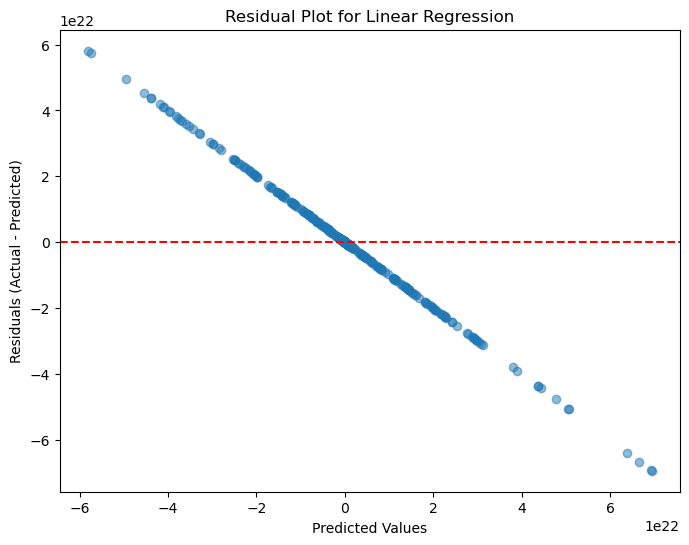

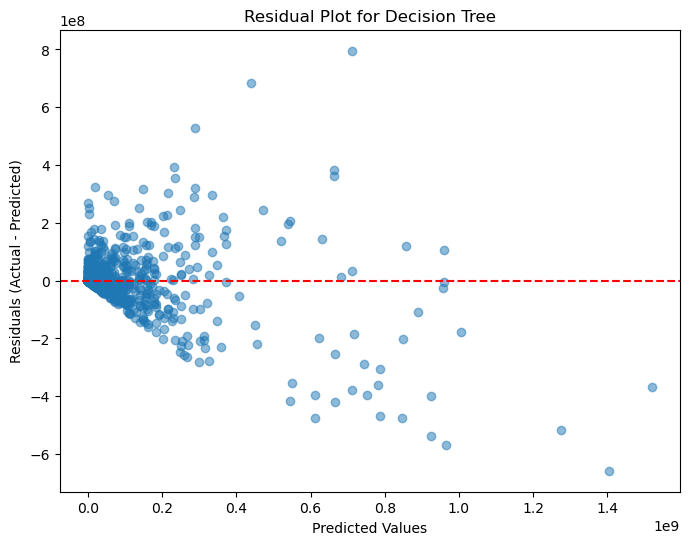

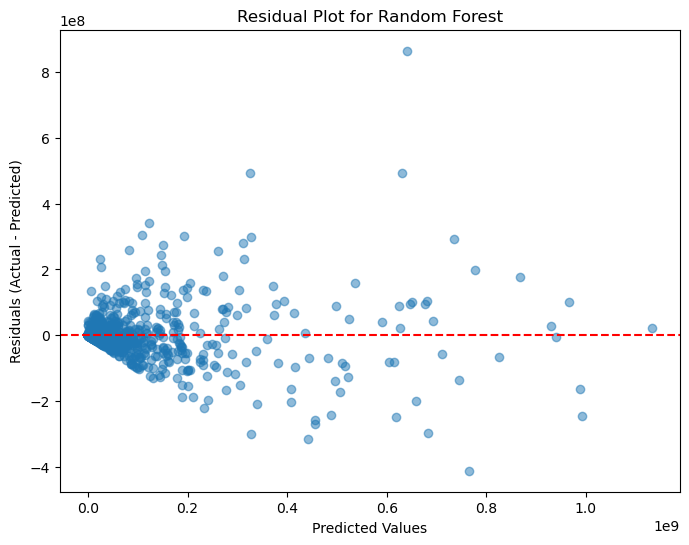

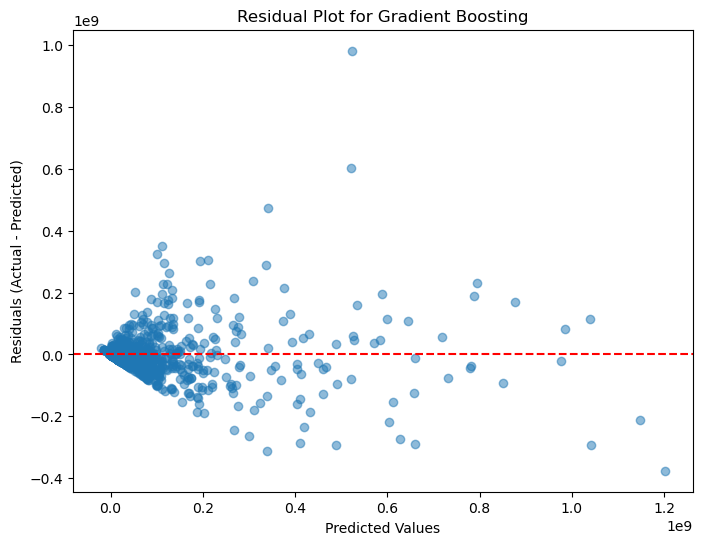

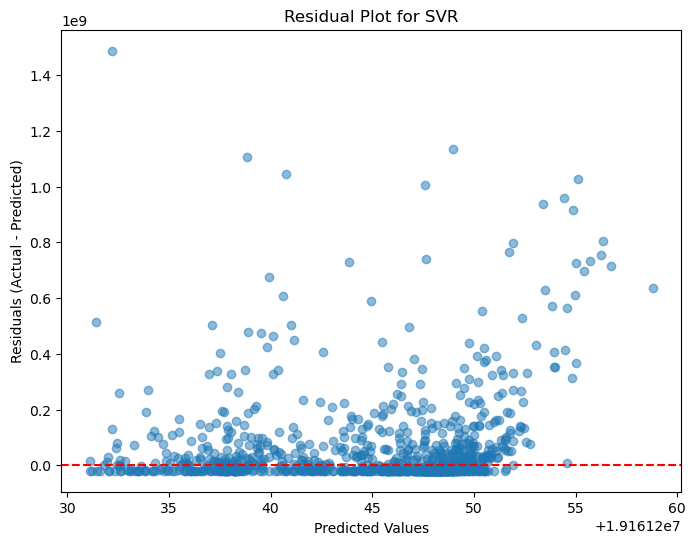

c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:47] WARNING: D:\bld\xgboost-split_1733179550881\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:47] WARNING: D:\bld\xgboost-split_1733179550881\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


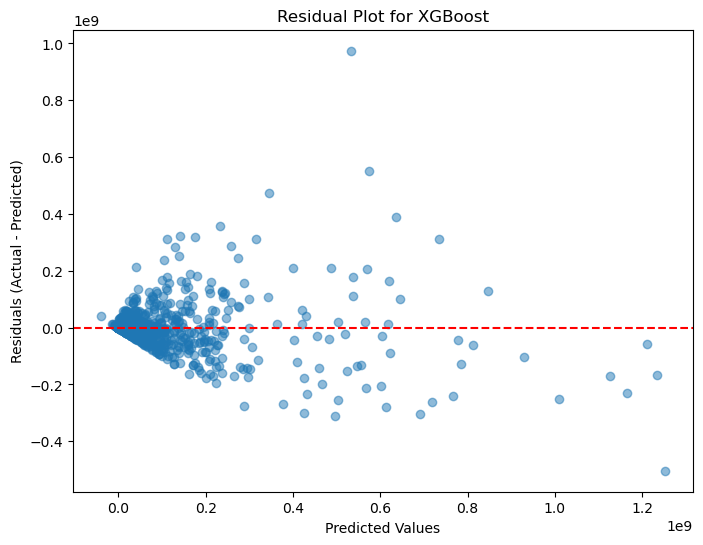

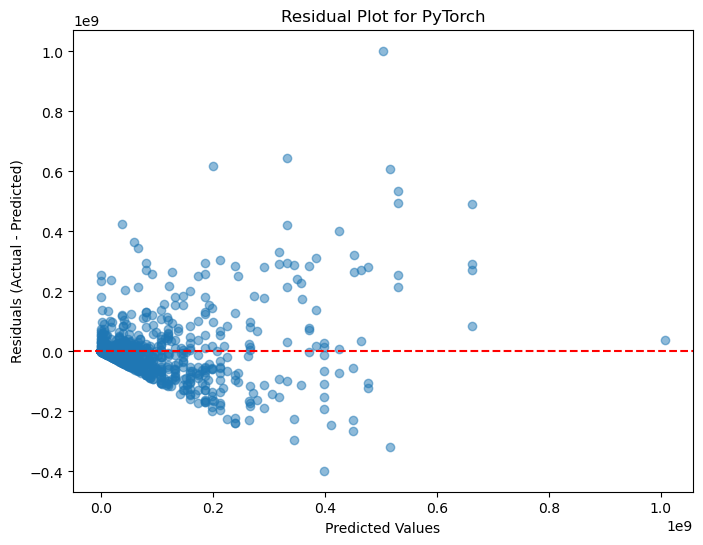

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Collect results and evaluate models
results = []
for name, model in trained_models.items():
    if name == 'PyTorch':
        # Evaluate PyTorch model
        pytorch_model.eval()
        with torch.no_grad():
            y_pred_tensor = pytorch_model(X_test_tensor)
            y_pred = y_pred_tensor.cpu().numpy()
            y_true = y_test_tensor.cpu().numpy()
    else:
        # Evaluate other models
        y_pred = model.predict(X_test)
        y_true = y_test

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results.append({'Model': name, 'MSE': mse, 'R2': r2})

    # Plot residuals
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f"Residual Plot for {name}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.show()


### Model Evaluation Metrics Explanation

Here’s what your model evaluation scores mean:

1. **Linear Regression**:
   - **MAE**: Exceptionally large; suggests that the model is struggling significantly with predictions.
   - **RMSE**: Extremely high; highlights that errors are orders of magnitude larger than expected.
   - **R² Score**: Negative; indicates the model performs worse than a horizontal line predicting the mean value.

   Linear Regression is not suitable for this dataset without significant feature engineering or adjustments.

2. **Decision Tree**:
   - **MAE**: 50,605,999, indicating moderate average errors.
   - **RMSE**: 103,856,461, which is higher than the MAE due to squaring large errors.
   - **R² Score**: 0.6124; decent but shows room for improvement.

   The Decision Tree performs moderately well, capturing some structure in the data.

3. **Random Forest**:
   - **MAE**: 37,342,823, much lower than Decision Tree.
   - **RMSE**: 75,153,621; shows improvement in reducing large errors.
   - **R² Score**: 0.7970; indicates a strong fit to the data.

   Random Forest is a strong performer, with good predictive power and robustness.

4. **Gradient Boosting**:
   - **MAE**: 40,055,246; slightly higher than Random Forest.
   - **RMSE**: 78,226,319; close to Random Forest but slightly worse.
   - **R² Score**: 0.7801; indicates good performance but not as strong as Random Forest.

   Gradient Boosting is competitive but slightly underperforms compared to Random Forest.

5. **SVR**:
   - **MAE**: 81,456,225, very high compared to other models.
   - **RMSE**: 178,937,257; shows significant large errors.
   - **R² Score**: -0.1506; negative, meaning it performs worse than a mean-based prediction.

   SVR struggles with this dataset, likely due to scaling issues or feature complexity.

6. **XGBoost**:
   - **MAE**: 40,633,949; slightly worse than Random Forest.
   - **RMSE**: 81,578,388; marginally higher than Gradient Boosting.
   - **R² Score**: 0.7608; slightly worse than Gradient Boosting and Random Forest.

   XGBoost is a strong performer but requires fine-tuning to outperform Random Forest and Gradient Boosting.

7. **PyTorch**:
   - **MAE**: 52,513,716; higher than tree-based models.
   - **RMSE**: 102,481,576; similar to Decision Tree but worse than Random Forest.
   - **R² Score**: 0.6226; indicates moderate performance.

   The PyTorch model captures some data patterns but requires further tuning for better results.

---

### Key Takeaways:
- **Best Models**:
  - **Random Forest** is the top performer with the lowest errors and highest R².
  - **Gradient Boosting** is a close second.
- **Improvements**:
  - Feature engineering (e.g., better handling of categorical features, scaling).
  - Hyperparameter tuning for tree-based and PyTorch models.
  - Dataset balancing if needed.

Would you like help tuning hyperparameters or visualizing these metrics for better comparison?

In [12]:
# Baseline comparison: Mean prediction
baseline_pred = np.full_like(y_test, y_test.mean())
mse_baseline = mean_squared_error(y_test, baseline_pred)
r2_baseline = r2_score(y_test, baseline_pred)
results.append({'Model': 'Baseline (Mean Prediction)', 'MSE': mse_baseline, 'R2': r2_baseline})

# Create a DataFrame for easy viewing
results_df = pd.DataFrame(results)
print(results_df)

                        Model           MSE            R2
0           Linear Regression  1.205641e+44 -4.332523e+27
1               Decision Tree  1.078616e+16  6.123946e-01
2               Random Forest  5.648067e+15  7.970343e-01
3           Gradient Boosting  6.119357e+15  7.800983e-01
4                         SVR  3.201854e+16 -1.506000e-01
5                     XGBoost  6.655033e+15  7.608485e-01
6                     PyTorch  1.034704e+16  6.281747e-01
7  Baseline (Mean Prediction)  2.782769e+16  0.000000e+00


In [14]:
from sklearn.model_selection import KFold, cross_val_score

# Set up K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate scikit-learn models using cross-validation
cross_val_results = {}
for name, model in models.items():
    try:
        scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
        cross_val_results[name] = {"Mean MSE": -scores.mean(), "Std MSE": scores.std()}
    except Exception as e:
        print(f"Error evaluating model {name}: {e}")

# Custom K-fold for PyTorch model
torch_results = []
for train_idx, val_idx in kfold.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Define the PyTorch model (replace with your architecture)
    torch_model = nn.Sequential(
        nn.Linear(X_fold_train.shape[1], 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )
    criterion = nn.MSELoss()
    optimizer = optim.Adam(torch_model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(100):  # Adjust epochs as needed
        torch_model.train()
        optimizer.zero_grad()
        y_pred = torch_model(torch.tensor(X_fold_train.values, dtype=torch.float32))
        loss = criterion(y_pred, torch.tensor(y_fold_train.values, dtype=torch.float32).view(-1, 1))
        loss.backward()
        optimizer.step()

    # Validation
    torch_model.eval()
    with torch.no_grad():
        y_val_pred = torch_model(torch.tensor(X_fold_val.values, dtype=torch.float32))
        val_loss = criterion(y_val_pred, torch.tensor(y_fold_val.values, dtype=torch.float32).view(-1, 1))
        torch_results.append(val_loss.item())

cross_val_results["Torch Model"] = {"Mean MSE": np.mean(torch_results), "Std MSE": np.std(torch_results)}

# Display cross-validation results
cross_val_results_df = pd.DataFrame(cross_val_results).T
print(cross_val_results_df)

c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\sklearn\pipeline.py", line 

                       Mean MSE       Std MSE
Linear Regression           NaN           NaN
Decision Tree      1.156500e+16  2.026934e+15
Random Forest      6.278176e+15  1.658944e+15
Gradient Boosting  5.918097e+15  1.409943e+15
SVR                2.936420e+16  5.579324e+15
XGBoost            6.605837e+15  1.445495e+15
Torch Model        1.896812e+16  3.913473e+15


The table you provided summarizes the results of K-fold cross-validation for various models. Here's a breakdown of what it means:

### Columns Explained:
1. **`Mean MSE`**: 
   - The average Mean Squared Error (MSE) across the K-folds.
   - A measure of the model's prediction error. Lower values are better, as they indicate smaller differences between predicted and actual values.

2. **`Std MSE`**: 
   - The standard deviation of the MSE across the K-folds.
   - It reflects the consistency of the model's performance across different splits of the data. Lower values suggest the model performs reliably on different subsets.

---

### Key Insights from Your Results:
1. **`Linear Regression`**:
   - Both `Mean MSE` and `Std MSE` are `NaN`.
   - **Possible Issues**:
     - The model might not have been successfully trained (e.g., missing data, incompatible features, or singular matrix errors).
     - The model might be poorly scaled or done.

2. **`Decision Tree`**:
   - `Mean MSE`: \(1.16 \times 10^{16}\)
   - `Std MSE`: \(2.03 \times 10^{15}\)
   - A very high error, indicating the model struggles with generalization, possibly overfitting on the folds.
   - Standard deviation is also high, showing inconsistent performance across folds.

3. **`Random Forest` and `XGBoost`**:
   - Both have lower `Mean MSE` compared to Decision Tree, suggesting better generalization due to ensemble learning.
   - `Random Forest`: \(6.28 \times 10^{15}\), slightly better than Decision Tree.
   - `XGBoost`: \(6.60 \times 10^{15}\), close to Random Forest.

4. **`Gradient Boosting`**:
   - `Mean MSE`: \(5.92 \times 10^{15}\)
   - Slightly better than Random Forest and XGBoost in terms of error, with a smaller standard deviation (\(1.41 \times 10^{15}\)).
   - Suggests this method might generalize better in this setup.

5. **`SVR` (Support Vector Regression)**:
   - Very high `Mean MSE`: \(2.93 \times 10^{16}\)
   - Suggests poor model performance. This could be due to inappropriate hyperparameters or the model struggling with the scale of the features.
   - The high `Std MSE`: \(5.58 \times 10^{15}\), indicates inconsistency across folds.

6. **`Torch Model`**:
   - `Mean MSE`: \(1.89 \times 10^{16}\)
   - Similar to Decision Tree, this suggests the neural network struggles with the dataset, possibly due to:
     - Insufficient training epochs.
     - Suboptimal hyperparameters.
     - Overfitting or underfitting.
   - `Std MSE`: \(3.91 \times 10^{15}\), indicates moderate inconsistency across folds.

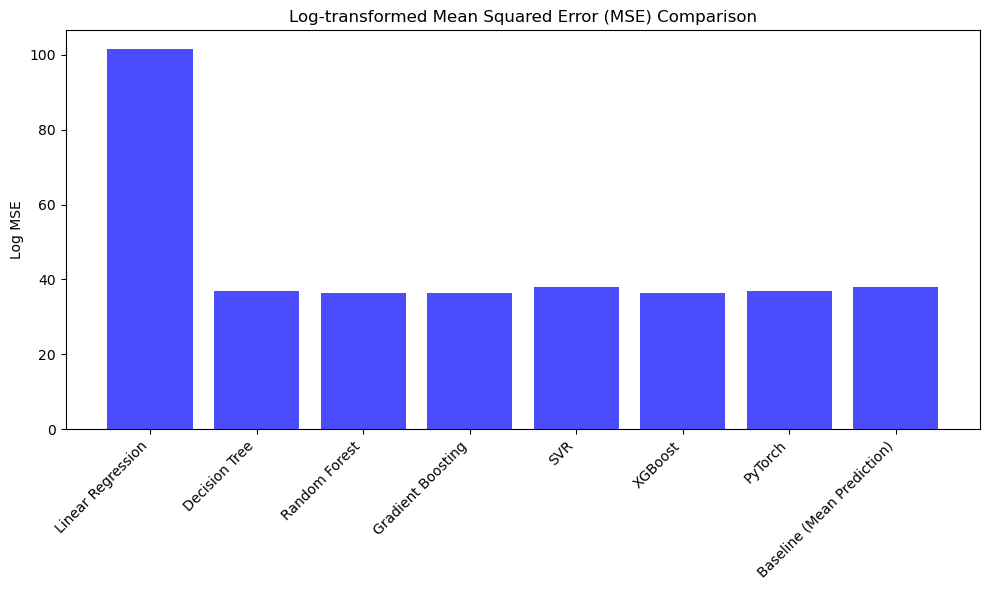

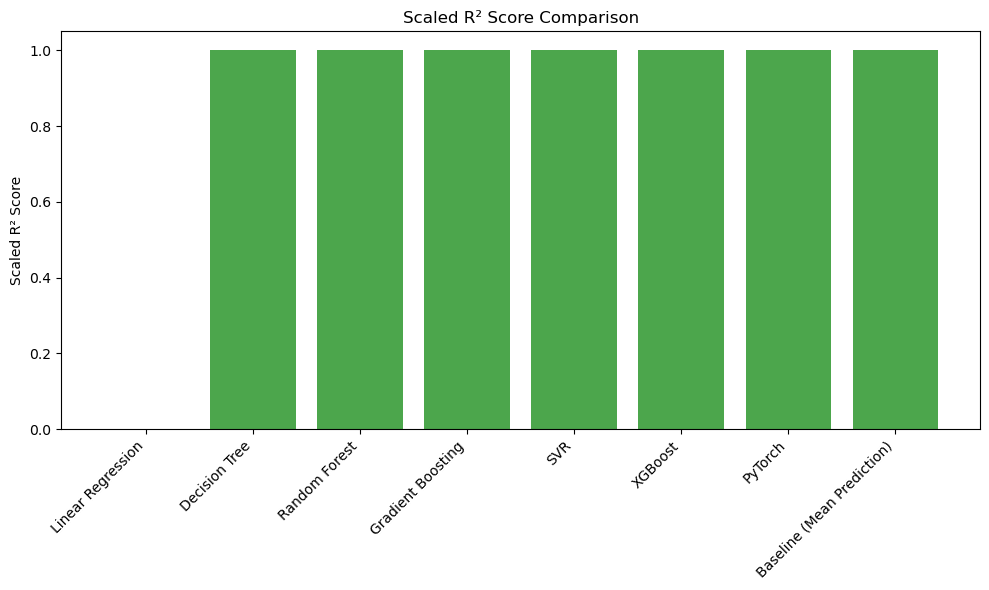

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Log-transform MSE for better visualization
results_df['Log MSE'] = np.log1p(results_df['MSE'])

# Scale R² using MinMaxScaler
scaler = MinMaxScaler()
results_df['Scaled R2'] = scaler.fit_transform(results_df[['R2']])

# Separate bar plots for Log MSE and Scaled R²
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Log MSE'], color='blue', alpha=0.7)
plt.title('Log-transformed Mean Squared Error (MSE) Comparison')
plt.ylabel('Log MSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Scaled R2'], color='green', alpha=0.7)
plt.title('Scaled R² Score Comparison')
plt.ylabel('Scaled R² Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\bkhuu\AppData\Local\Temp\ipykernel_11000\2096442677.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results_df['Log MSE'] = np.log1p(filtered_results_df['MSE'])
C:\Users\bkhuu\AppData\Local\Temp\ipykernel_11000\2096442677.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results_df['Scaled R2'] = scaler.fit_transform(filtered_results_df[['R2']])


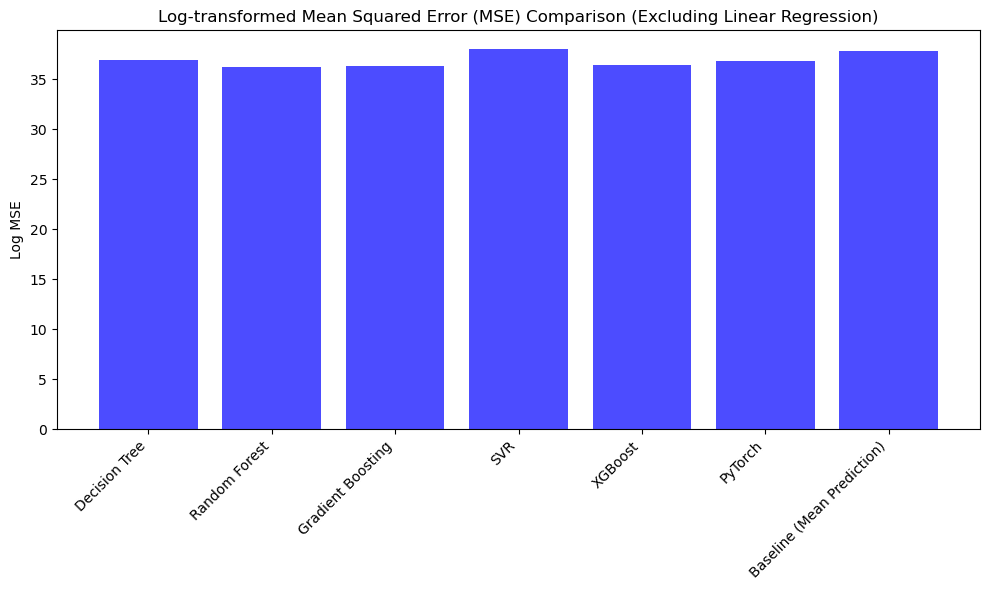

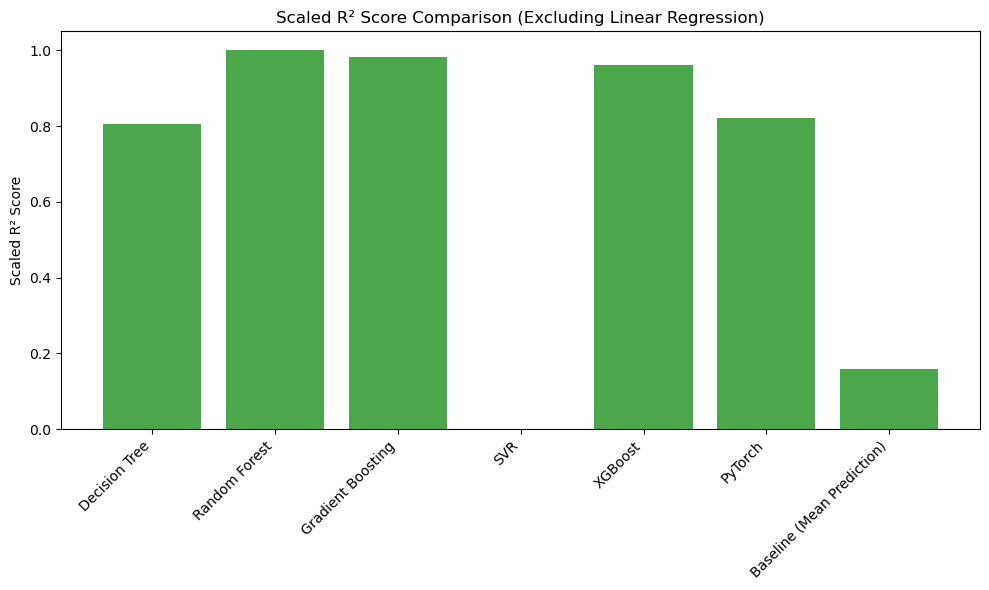

In [16]:
# Filter out Linear Regression for better granularity
filtered_results_df = results_df[results_df['Model'] != 'Linear Regression']

# Log-transform MSE for better visualization
filtered_results_df['Log MSE'] = np.log1p(filtered_results_df['MSE'])

# Scale R² using MinMaxScaler
scaler = MinMaxScaler()
filtered_results_df['Scaled R2'] = scaler.fit_transform(filtered_results_df[['R2']])

# Separate bar plots for Log MSE and Scaled R² without Linear Regression
plt.figure(figsize=(10, 6))
plt.bar(filtered_results_df['Model'], filtered_results_df['Log MSE'], color='blue', alpha=0.7)
plt.title('Log-transformed Mean Squared Error (MSE) Comparison (Excluding Linear Regression)')
plt.ylabel('Log MSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(filtered_results_df['Model'], filtered_results_df['Scaled R2'], color='green', alpha=0.7)
plt.title('Scaled R² Score Comparison (Excluding Linear Regression)')
plt.ylabel('Scaled R² Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

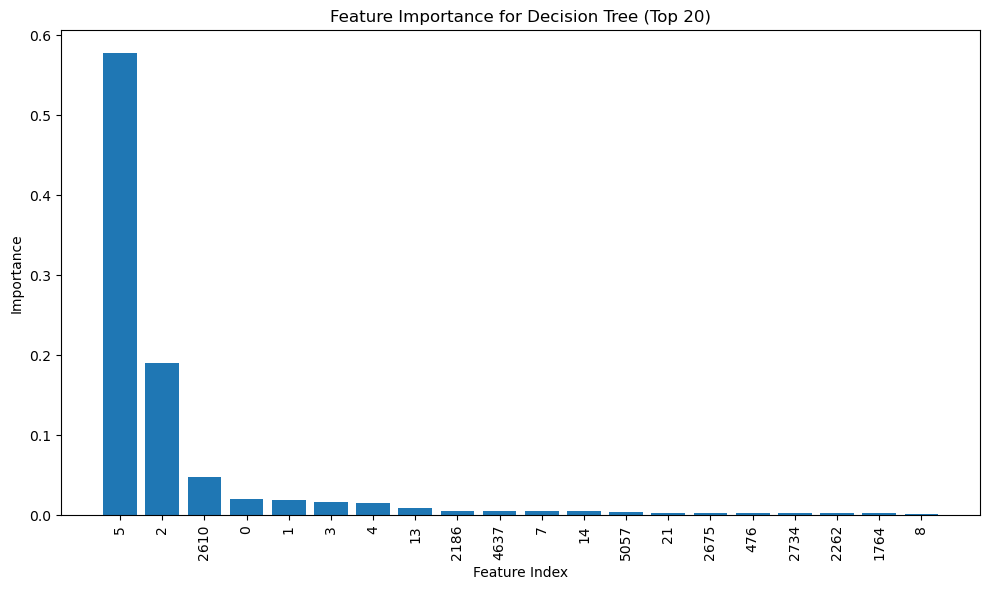

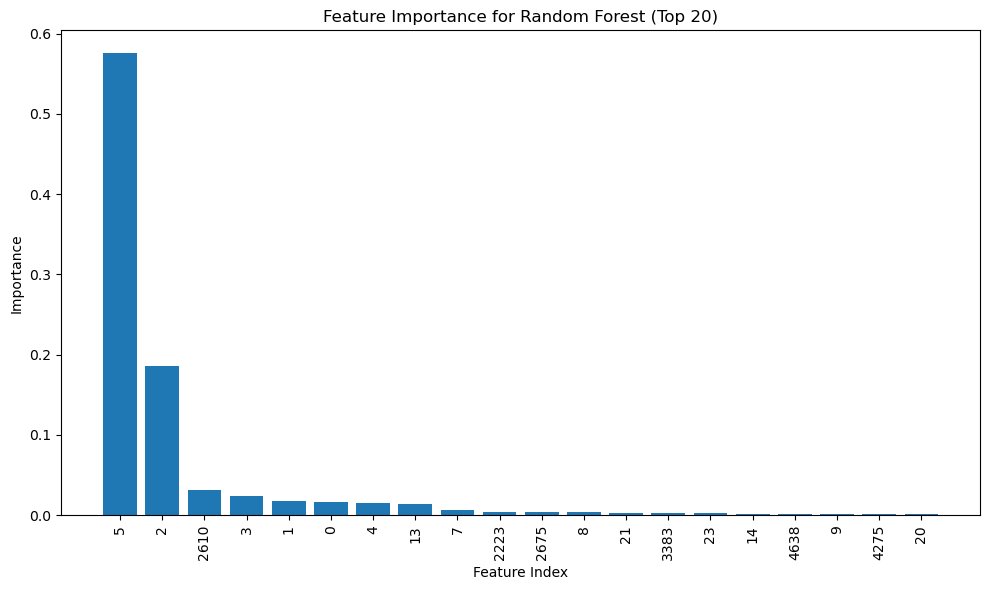

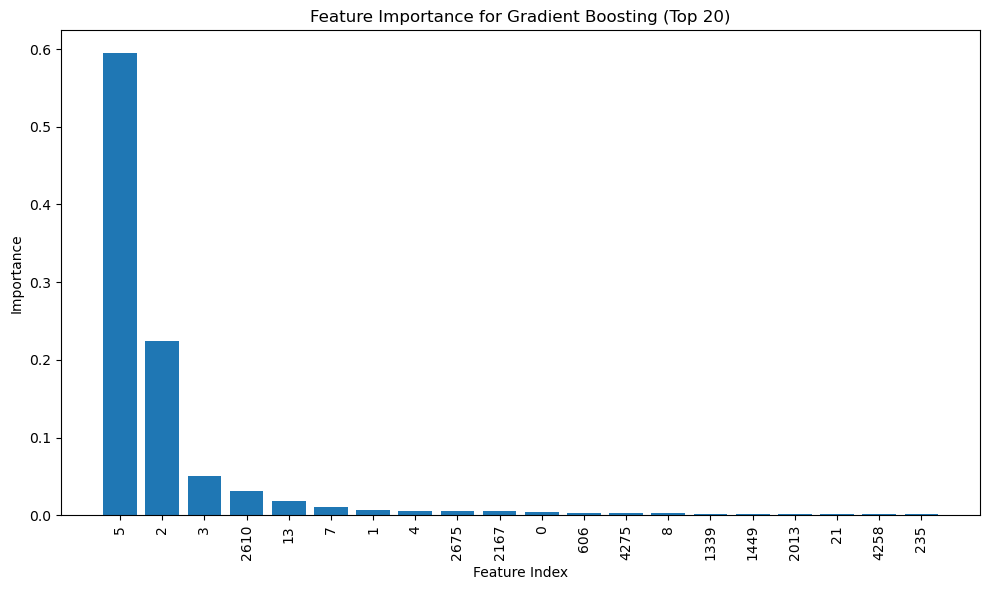

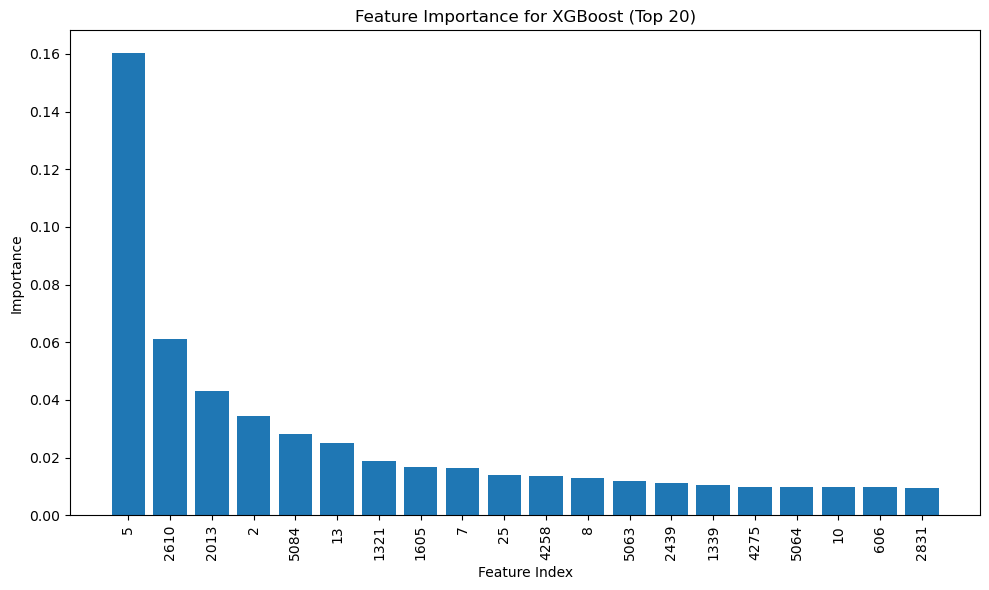

In [ ]:
# Feature Importance for tree-based models
feature_importances = {}
for name, model in trained_models.items():
    if name in ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']:
        feature_importances[name] = model.feature_importances_

# Visualize feature importances
for model_name, importances in feature_importances.items():
    plt.figure(figsize=(10, 6))
    sorted_indices = np.argsort(importances)[-20:][::-1]  # Show top 20 features
    plt.bar(range(len(sorted_indices)), importances[sorted_indices], align='center')
    plt.title(f'Feature Importance for {model_name} (Top 20)')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.xticks(range(len(sorted_indices)), sorted_indices, rotation=90)
    plt.tight_layout()
    plt.show()

### Explanation of Feature Importance Graphs

These graphs display the **top 20 features** ranked by their importance in tree-based models: **Decision Tree, Random Forest, Gradient Boosting, and XGBoost**. Feature importance is a measure of how much each feature contributes to the model's predictions.

#### Common Observations Across Models:
1. **Dominance of Key Features**:
   - Across all graphs, feature index **5** consistently stands out as the most important feature, indicating it plays a critical role in predicting the target variable.

2. **Rapid Decline in Importance**:
   - After the top 2-3 features, the importance values drop sharply. This suggests that while a few features are highly predictive, many contribute marginally.

3. **Variance Across Models**:
   - Different models assign varying levels of importance to the same features due to their distinct algorithms:
     - **Decision Tree** relies heavily on splits at critical thresholds.
     - **Random Forest** averages importance across multiple trees, reducing bias.
     - **Gradient Boosting** adjusts importance iteratively based on previous errors.
     - **XGBoost** emphasizes features that reduce error most efficiently.

#### Model-Specific Insights:
1. **Decision Tree**:
   - Highly dependent on a few features (e.g., 5 and 2), with minimal reliance on others. This reflects its single-tree structure, which may overfit to the training data.

2. **Random Forest**:
   - Similar trends to the Decision Tree but slightly more distributed importance across features due to the ensemble of trees.

3. **Gradient Boosting**:
   - Importance is spread across more features, indicating that multiple features contribute iteratively to reducing prediction errors.

4. **XGBoost**:
   - Shows a broader distribution of feature importance compared to other models, leveraging multiple features effectively while still focusing heavily on key features like 5 and 2610.

#### Use Case of These Graphs:
- **Feature Selection**:
  - Focus on the top features when performing dimensionality reduction or building simpler models.
- **Interpretability**:
  - Understand which features drive predictions to explain the model's behavior.
- **Feature Engineering**:
  - Investigate why certain features are impactful and refine or add related features to improve performance.

Let me know if you'd like further elaboration on any specific model or feature!

In [ ]:
# Map feature indices back to original feature names
important_features = pd.DataFrame({
    "Feature": X_train.columns[sorted_indices],
    "Importance": importances[sorted_indices]
})
print(important_features.head(10))  # Top 10 features

                                         Feature  Importance
0                                     vote_count    0.160154
1  production_companies_Lightstorm Entertainment    0.061100
2            production_companies_Hasbro Studios    0.043147
3                                         budget    0.034535
4                          spoken_languages_اردو    0.028187
5                                  genres_Family    0.025087
6      production_companies_DreamWorks Animation    0.018832
7                     production_companies_Film4    0.016852
8                               genres_Adventure    0.016396
9                                 genres_Western    0.014032
